In [23]:
import numpy as np
from helpers import *
from implementations import *
import matplotlib.pyplot as plt

In [24]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data('data/dataset/')

In [25]:
NAN_PERCENTAGE = 0.2

# Find columns with more than NAN_PERCENTAGE missing values in x_train
nan_cols_train = np.where(np.sum(np.isnan(x_train), axis=0) > NAN_PERCENTAGE * x_train.shape[0])[0]

# Remove those columns from both x_train and x_test
x_train = np.delete(x_train, nan_cols_train, axis=1)
x_test = np.delete(x_test, nan_cols_train, axis=1)

# Find the columns where the values are all the same
same_cols_train = np.where(np.all(x_train == x_train[0,:], axis=0))[0]

# Remove those columns from both x_train and x_test
x_train = np.delete(x_train, same_cols_train, axis=1)
x_test = np.delete(x_test, same_cols_train, axis=1)

# Replace NaN values with column means
col_means = np.nanmean(x_train, axis=0)
train_nans = np.isnan(x_train)
x_train[train_nans] = np.take(col_means, np.where(train_nans)[1])
test_nans = np.isnan(x_test)
x_test[test_nans] = np.take(col_means, np.where(test_nans)[1])

# Get the mean and standard deviation of each column in x_train
means = np.mean(x_train, axis=0)
stds = np.std(x_train, axis=0)

# If a column has a standard deviation of 0, remove it from x_train, x_test and the means and stds arrays
zero_std_cols = np.where(stds == 0)[0]
x_train = np.delete(x_train, zero_std_cols, axis=1)
x_test = np.delete(x_test, zero_std_cols, axis=1)
means = np.delete(means, zero_std_cols)
stds = np.delete(stds, zero_std_cols)

# Standardize x_train and x_test
x_train = (x_train - means) / stds
x_test = (x_test - means) / stds

# Convert y_train to 0 and 1
y_train[y_train == -1] = 0

In [26]:
print(x_train.shape)
print(x_test.shape)

(328135, 143)
(109379, 143)


/Users/hadriensevel/Library/Mobile Documents/com~apple~CloudDocs/EPFL/Master/Machine Learning/ml-project-1-the-overfitters/implementations.py:291: RuntimeWarning: divide by zero encountered in log
  -np.sum(y * np.log(sigmoid(tx @ w)) + (1 - y) * np.log(1 - sigmoid(tx @ w)))
/Users/hadriensevel/Library/Mobile Documents/com~apple~CloudDocs/EPFL/Master/Machine Learning/ml-project-1-the-overfitters/implementations.py:291: RuntimeWarning: invalid value encountered in multiply
  -np.sum(y * np.log(sigmoid(tx @ w)) + (1 - y) * np.log(1 - sigmoid(tx @ w)))


gamma =  0.3262874457611131
lambda =  0
loss =  0.6697248360979814
Best gamma =  0.3262874457611131
Best lambda =  0
Best loss =  0.6697248360979814


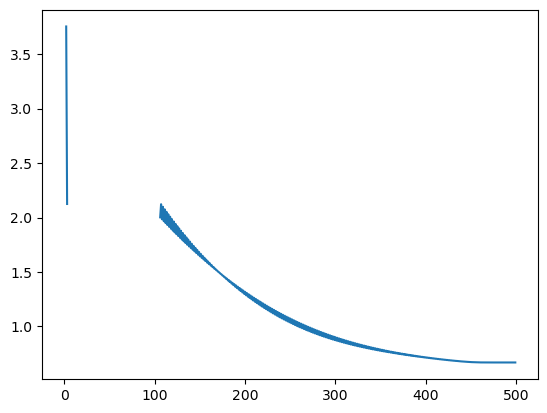

In [27]:
# Train our model
NBR_ITER = 500

# Try different values for gamma and lambda
gammas = [4]
lambdas = [0]

best_gamma = None
best_lambda = None
best_loss = np.inf
best_w = np.ones(x_train.shape[1])
initial_w = 1e-5 * np.ones(x_train.shape[1])
losses = []

for gamma in gammas:
    for lambda_ in lambdas:

        w = initial_w

        for _ in range(NBR_ITER):
            gamma*=0.995
            # compute gradient
            grad = compute_gradient_neg_log(y_train, x_train, w) + 2 * lambda_ * w
            # update w by gradient
            w = w - gamma * grad
            # compute loss
            loss = compute_loss_neg_log(y_train, x_train, w) + lambda_ * np.linalg.norm(w) ** 2
            losses.append(loss)

    
        if loss < best_loss:
            best_loss = loss
            best_gamma = gamma
            best_lambda = lambda_
            best_w = w

        print("gamma = ", gamma)
        print("lambda = ", lambda_)
        print("loss = ", loss)

        # Plot the loss
        plt.plot(losses)

print("Best gamma = ", best_gamma)
print("Best lambda = ", best_lambda)
print("Best loss = ", best_loss)

#GAMMA =  0.3
#loss =  0.5887492781783168

In [21]:
best_w

array([ 3.62420006e-03,  2.29982526e-02, -2.33414727e-02,  1.57606509e-03,
       -1.35018921e-03, -1.31424061e-02,  6.82499099e-03, -1.24142867e-03,
       -1.24142867e-03,  1.25953864e-01, -2.16737627e-02, -2.27166448e-03,
       -1.27213717e-02,  8.74039103e-03, -5.39524790e-03, -3.24706421e-03,
       -5.60392312e-02, -3.45160811e-02, -2.27822618e-02, -7.20003717e-02,
       -7.35059326e-02, -2.35461942e-05, -1.26699023e-02,  2.04085466e-04,
       -4.01171347e-02,  2.88428221e-03, -3.90500018e-03, -3.08229211e-02,
       -6.85013378e-02, -1.03709874e-01, -2.04801313e-02, -4.68754128e-03,
        8.46537857e-03, -3.10072990e-02,  3.56122151e-02, -2.70828625e-03,
        1.12549034e-02,  2.09912347e-02, -7.94529673e-03,  6.03108461e-03,
       -1.24723979e-02, -3.53994332e-02, -3.14436527e-03,  6.02394862e-03,
       -3.01429729e-02,  1.01391904e-02, -8.29278638e-05, -3.22997510e-02,
        1.56392948e-02,  5.33164685e-02,  4.15565965e-03, -8.68029909e-03,
        1.19410799e-03,  

In [6]:
# Function to predict the labels for the test data
def predict_labels(w, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = sigmoid(data.dot(w))
    y_pred[np.where(y_pred <= 0.5)] = 0
    y_pred[np.where(y_pred > 0.5)] = 1
    return y_pred

In [7]:
# Generate predictions and save ouput in csv format for submission:
OUTPUT_PATH = 'data/submission.csv'

y_pred = predict_labels(best_w, x_test)
# Convert 0 and 1 back to -1 and 1
y_pred[y_pred == 0] = -1
create_csv_submission(test_ids, y_pred, OUTPUT_PATH)